<a href="https://colab.research.google.com/github/hamuntech/Similarity-Search-using-Transfer-Learning/blob/main/Similarity_Search_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the Caltech101 dataset using gdown (https://github.com/wkentaro/gdown). Caltech101 dataset contatins 101 categories. Remove the 102nd category called ‘BACKGROUND_Google’.

In [ ]:
!mkdir -p ../../datasets
!pip install gdown
!gdown https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp --output ../../datasets/caltech101.tar.gz
!tar -xvzf ../../datasets/caltech101.tar.gz --directory ../../datasets
!mv ../../datasets/101_ObjectCategories ../../datasets/caltech101
!rm -rf ../../datasets/caltech101/BACKGROUND_Google

Streaming output truncated to the last 5000 lines.
101_ObjectCategories/chair/image_0005.jpg
101_ObjectCategories/chair/image_0006.jpg
101_ObjectCategories/chair/image_0007.jpg
101_ObjectCategories/chair/image_0008.jpg
101_ObjectCategories/chair/image_0010.jpg
101_ObjectCategories/chair/image_0011.jpg
101_ObjectCategories/chair/image_0012.jpg
101_ObjectCategories/chair/image_0013.jpg
101_ObjectCategories/chair/image_0014.jpg
101_ObjectCategories/chair/image_0016.jpg
101_ObjectCategories/chair/image_0017.jpg
101_ObjectCategories/chair/image_0018.jpg
101_ObjectCategories/chair/image_0019.jpg
101_ObjectCategories/chair/image_0020.jpg
101_ObjectCategories/chair/image_0022.jpg
101_ObjectCategories/chair/image_0023.jpg
101_ObjectCategories/chair/image_0024.jpg
101_ObjectCategories/chair/image_0025.jpg
101_ObjectCategories/chair/image_0026.jpg
101_ObjectCategories/chair/image_0028.jpg
101_ObjectCategories/chair/image_0029.jpg
101_ObjectCategories/chair/image_0030.jpg
101_ObjectCategories/chai

In [ ]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import time
import PIL
from PIL import Image

In [ ]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #Load the ResNet-50 model without the top classification layers

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
#Define a function that takes an image path, loads the image, resizes it to proper dimensions supported by ResNet-50, extracts the features, and then normalizes them
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [ ]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
    return file_list

In [ ]:
# Run feature extraction over the entire dataset and time it
root_dir = '../../datasets/caltech101'
filenames = sorted(get_file_list(root_dir))

feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
#We will use scikit-learn for finding nearest neighbors of the query features
from sklearn.neighbors import NearestNeighbors

In [ ]:
#Train NearestNeighbors on feature_list for 5 immediate neighbors for each example in the dataset
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(feature_list)

In [ ]:
filenames = sorted(get_file_list(root_dir))

In [ ]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  8677
Number of features per image =  100352


In [ ]:
# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]
    
# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)

In [ ]:
#Test the image paths
for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors(
        [feature_list[random_image_index]])
    # Don't take the first closest image as it will be the same image
    print("Random Image Path: ", filenames[random_image_index])
    print("Next Image Path: ", filenames[indices[0][1]])
    print("Combined Image Path", [filenames[random_image_index]] + [filenames[indices[0][1]]])

Random Image Path:  ../../datasets/caltech101/elephant/image_0056.jpg
Next Image Path:  ../../datasets/caltech101/elephant/image_0039.jpg
Combined Image Path ['../../datasets/caltech101/elephant/image_0056.jpg', '../../datasets/caltech101/elephant/image_0039.jpg']
Random Image Path:  ../../datasets/caltech101/Motorbikes/image_0624.jpg
Next Image Path:  ../../datasets/caltech101/Motorbikes/image_0091.jpg
Combined Image Path ['../../datasets/caltech101/Motorbikes/image_0624.jpg', '../../datasets/caltech101/Motorbikes/image_0091.jpg']
Random Image Path:  ../../datasets/caltech101/bass/image_0040.jpg
Next Image Path:  ../../datasets/caltech101/bass/image_0041.jpg
Combined Image Path ['../../datasets/caltech101/bass/image_0040.jpg', '../../datasets/caltech101/bass/image_0041.jpg']
Random Image Path:  ../../datasets/caltech101/mandolin/image_0033.jpg
Next Image Path:  ../../datasets/caltech101/mandolin/image_0039.jpg
Combined Image Path ['../../datasets/caltech101/mandolin/image_0033.jpg', '

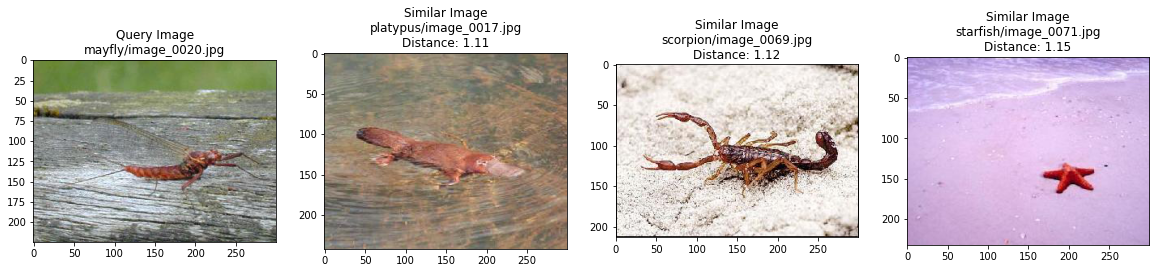

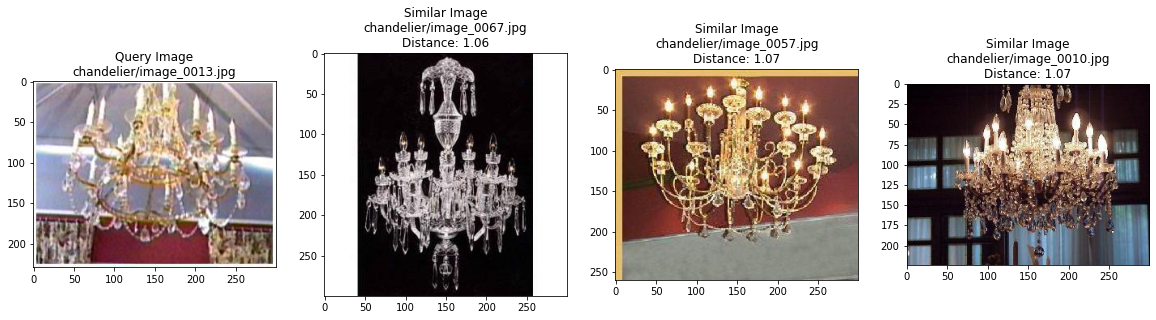

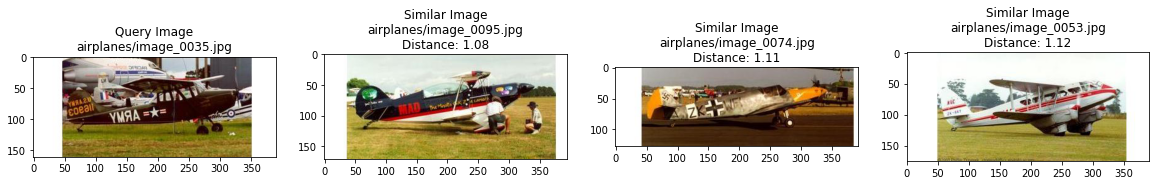

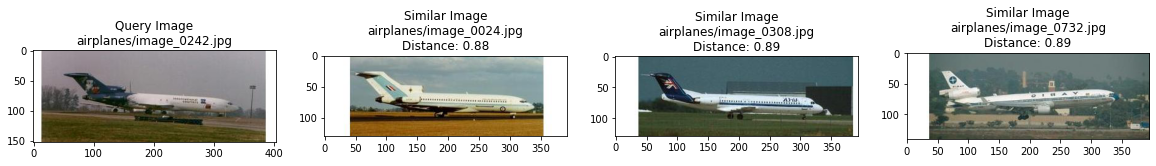

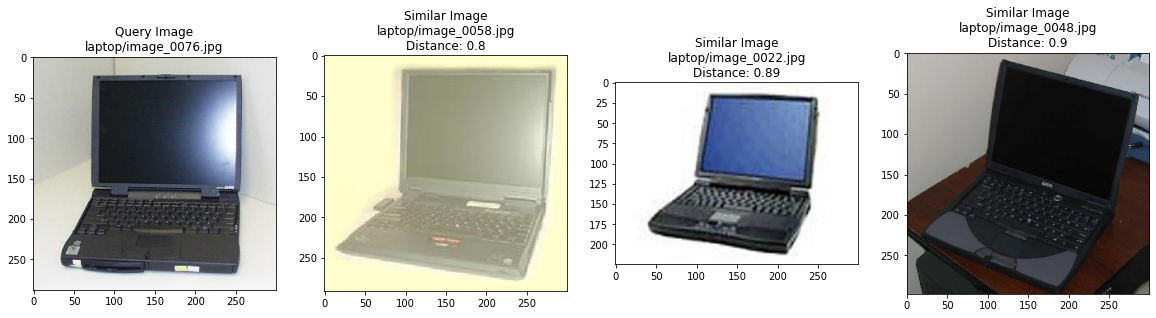

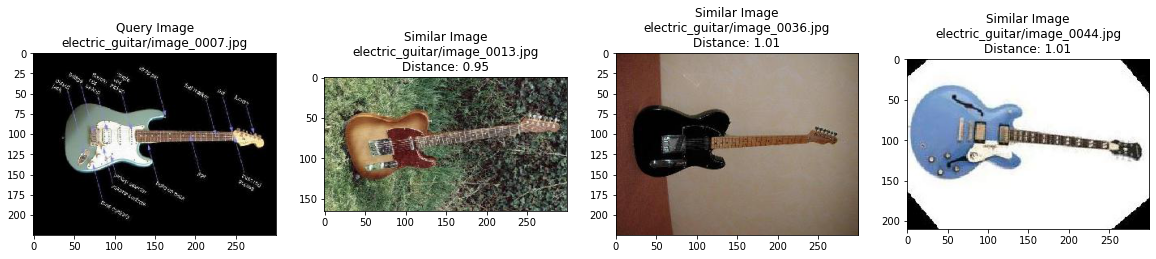

In [ ]:
for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

We may visualize the dataset using t-SNE algorithm as follows. Did not work on Google Colab due to RAM limitations

In [ ]:
from sklearn.manifold import TSNE

selected_features = feature_list[:]
n_components = 2
verbose = 1
perplexity = 30
n_iter = 1000
metric = 'euclidean'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(selected_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

In [ ]:
selected_class_ids = class_ids[:]
color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=selected_class_ids,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

In [ ]:
#Helper function to render a t-SNE plot
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.show()

In [ ]:
selected_filenames = filenames[:]
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)